In [1]:
import numpy as np
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import scipy as sp
import faraway.utils

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20, 10)

In [2]:
titanic = pd.read_csv("./train.csv")
titanic.drop(columns=["PassengerId"], inplace=True)

print(titanic.shape)
titanic.head()

(891, 11)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
X = titanic.drop(columns="Survived")
y = titanic["Survived"]

## Splitting
is actually not required here, because it is already done by Kaggle. </br>
The score on the leaderboard serves as a final evaluation of our model. </br>
Having completely forgotten about it, I've decided not to remove this chunk of code. </br>
In the next sections only the `X`, `y` are used.
</br></br>
An obvious choice here is to split preserving the proportion of survived/not survided. </br>
We'll shuffle to mitigate any order-specific patterns in the data.

In [4]:
titanic.shape

(891, 11)

In [5]:
from sklearn.model_selection import train_test_split

stratify = ["Survived", "Pclass", "Sex"]
train, test = train_test_split(
    titanic, test_size = 0.2, 
    stratify=titanic[stratify], random_state=42
)

In [6]:
y_train = train["Survived"]
y_test = test["Survived"]

X_train = train.drop(columns="Survived")
X_test = test.drop(columns="Survived")

In [7]:
def get_ratios(train, test, column):
    res = pd.DataFrame({
        "train": train[column].value_counts() / train.shape[0],
        "test": test[column].value_counts() / test.shape[0],
    })
    res.index.name = column
    return res

get_ratios(train, test, "Survived")

,train,test
Survived,,
0,0.615169,0.620112
1,0.384831,0.379888


In [8]:
get_ratios(X_train, X_test, "Pclass")

,train,test
Pclass,,
3,0.550562,0.553073
1,0.241573,0.245810
2,0.207865,0.201117


In [9]:
get_ratios(X_train, X_test, "Sex")

,train,test
Sex,,
male,0.648876,0.642458
female,0.351124,0.357542


## EDA

In [10]:
df = pd.concat([X, y], axis=1)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Name      891 non-null    object 
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Ticket    891 non-null    object 
 7   Fare      891 non-null    float64
 8   Cabin     204 non-null    object 
 9   Embarked  889 non-null    object 
 10  Survived  891 non-null    int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


### Age

In [12]:
def survived_summary(col, df=df):
    df_t = pd.concat([df[["Survived"]], df[col]], axis=1)
    summ = df_t.groupby(col).agg(["count", "sum"])
    summ.loc[:, ("Survived", "ratio")] = summ["Survived"]["sum"] / summ["Survived"]["count"]
    # to percent
    summ.loc[:, ("Survived", "ratio")] = summ[
        ("Survived", "ratio")
    ].mul(100).round(1).astype(str) + '%'
    return summ

<AxesSubplot:xlabel='Age', ylabel='Survived'>

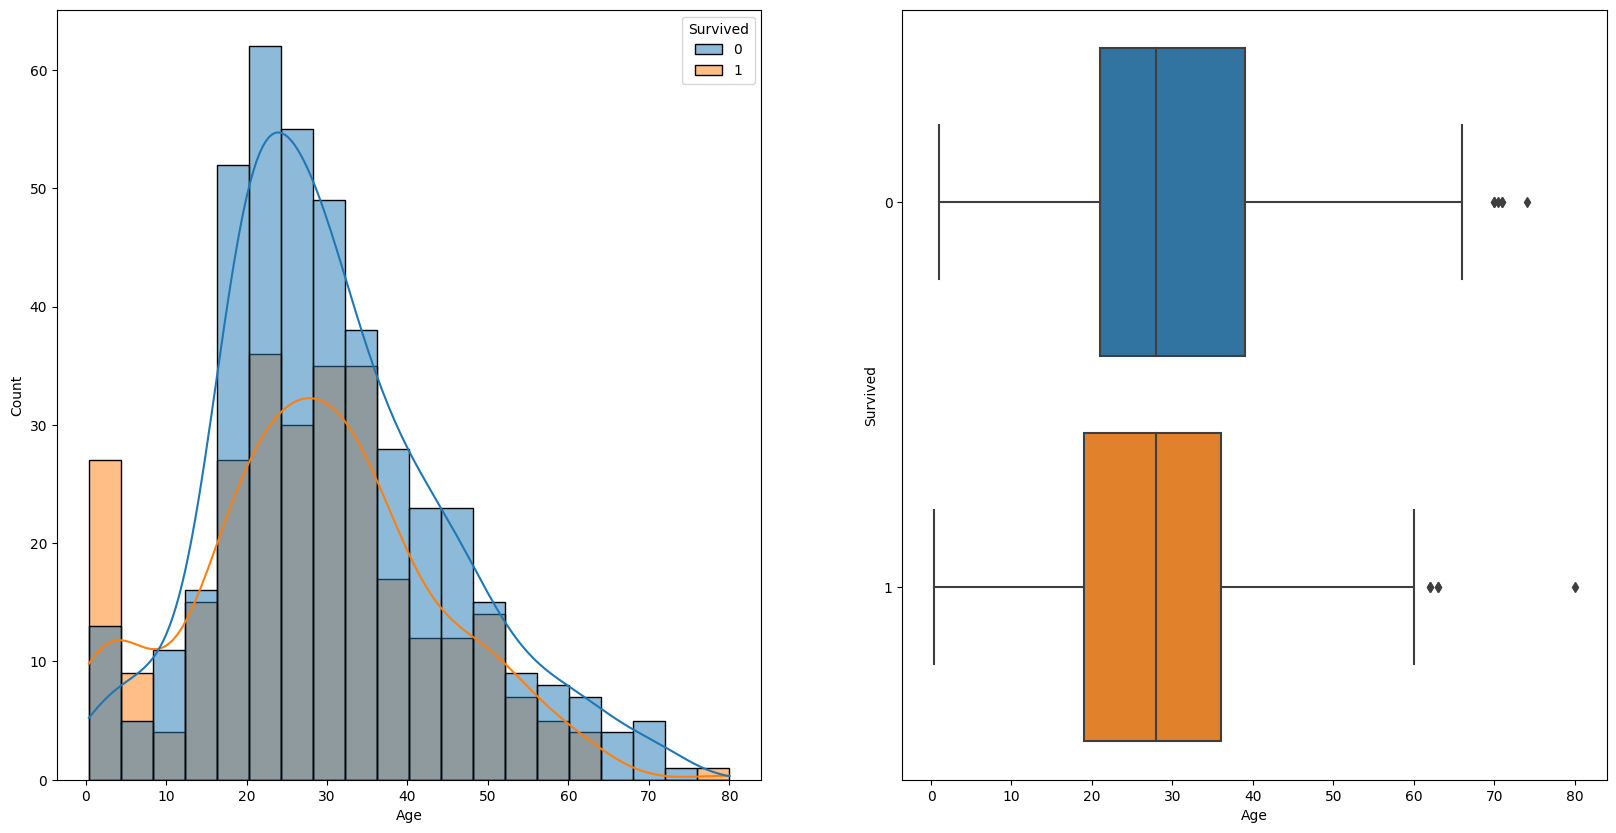

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2)


sns.histplot(x="Age", hue="Survived", data=df, kde=True, ax=ax1)
sns.boxplot(x="Age", y="Survived", data=df, ax=ax2, orient="h")

In [14]:
df["age_cat"] = pd.cut(
    df["Age"], [0, 10, 20, 35, 50, np.inf], 
    right=False, labels=["<10", "10-20", "20-35", "35-50", ">50"]
)
survived_summary("age_cat")

Survived            
           count  sum  ratio
age_cat                     
<10           62   38  61.3%
10-20        102   41  40.2%
20-35        315  117  37.1%
35-50        161   67  41.6%
>50           74   27  36.5%

Observations: 
- children are more likely to survive;
- The survived are generally more young, though there are "very old" outliers.

### Sex

In [15]:
survived_summary(["Sex"])

Survived            
          count  sum  ratio
Sex                        
female      314  233  74.2%
male        577  109  18.9%

We clearly see that women are much more likely to survive. </br>
$\hat{\mathbb{P}}(Surv|Woman) = 75\%$, while $\hat{\mathbb{P}}(Surv|Man)=19\%$ </br>
We may try to unravel a bit, add some information to get a better insight:


In [16]:
survived_summary(["Sex", "Pclass"])

Survived           
                 count sum  ratio
Sex    Pclass                    
female 1            94  91  96.8%
       2            76  70  92.1%
       3           144  72  50.0%
male   1           122  45  36.9%
       2           108  17  15.7%
       3           347  47  13.5%

Not only this gives a peak at significance of `Pclass`, but it also shows that 
$$\hat{\mathbb{P}}(Surv|Woman, class=1) = 97\%$$
$$\hat{\mathbb{P}}(Surv|Woman, class=2) = 92\%$$
Women (and man likewise) from the upper classes are extremely likely to survive

### Pclass

<AxesSubplot:xlabel='Pclass', ylabel='count'>

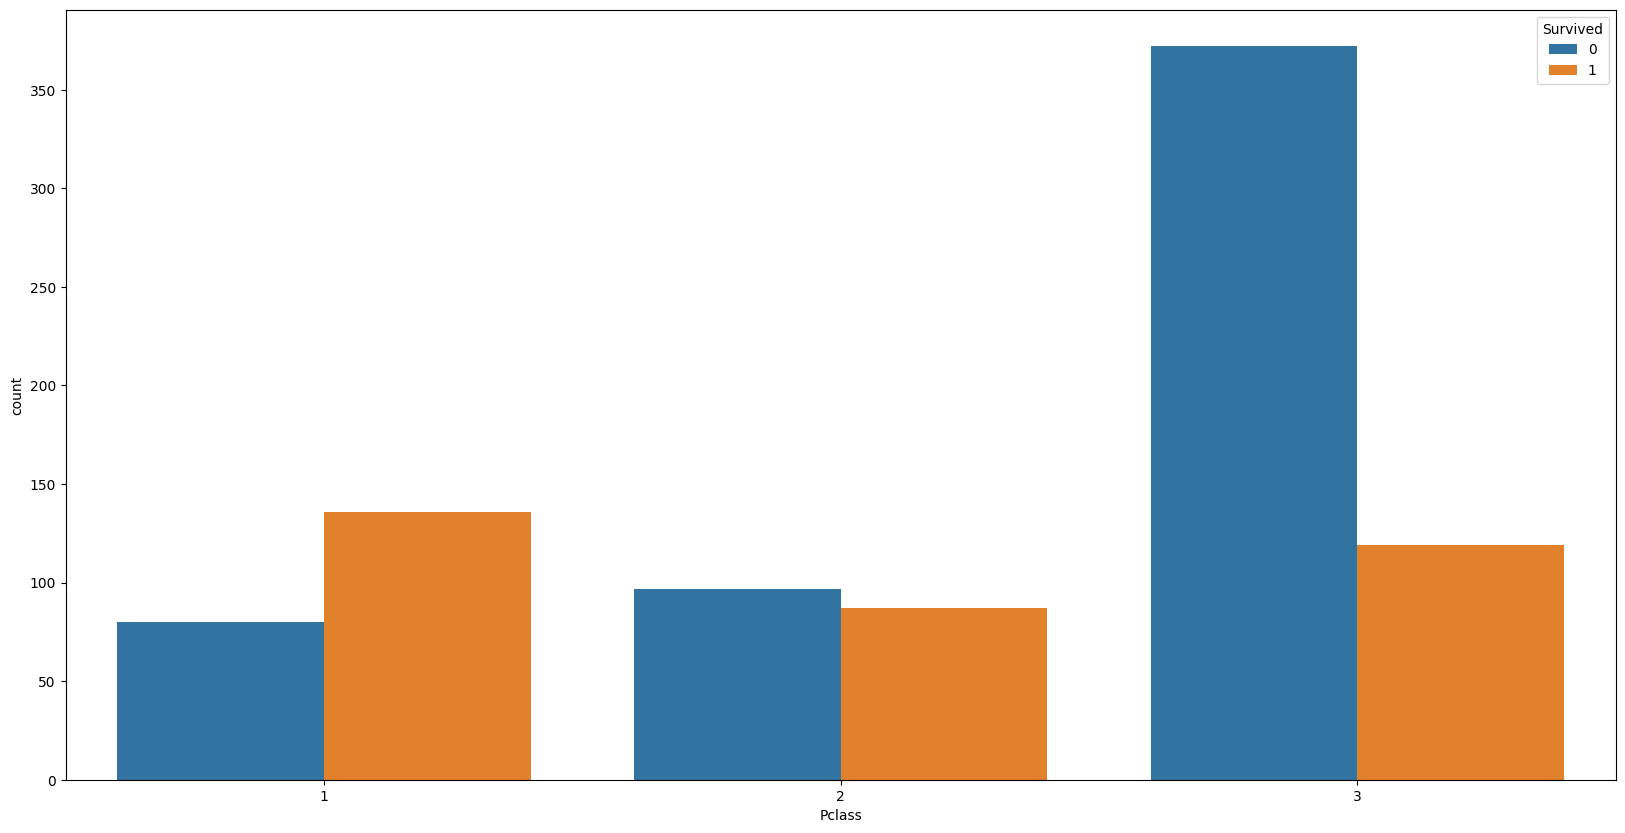

In [17]:
sns.countplot(x="Pclass", hue="Survived", data=df)

In [18]:
survived_summary("Pclass")

Survived            
          count  sum  ratio
Pclass                     
1           216  136  63.0%
2           184   87  47.3%
3           491  119  24.2%

Observation: people from higher classes are more likely to survive

### Ralatives aboard

In [19]:
survived_summary("Parch")

Survived            
         count  sum  ratio
Parch                     
0          678  233  34.4%
1          118   65  55.1%
2           80   40  50.0%
3            5    3  60.0%
4            4    0   0.0%
5            5    1  20.0%
6            1    0   0.0%

In [20]:
survived_summary(["Sex", "Pclass", "SibSp", ])

Survived            
                       count sum   ratio
Sex    Pclass SibSp                     
female 1      0           49  48   98.0%
              1           40  38   95.0%
              2            3   3  100.0%
              3            2   2  100.0%
       2      0           44  41   93.2%
              1           28  25   89.3%
              2            3   3  100.0%
              3            1   1  100.0%
       3      0           81  48   59.3%
              1           38  17   44.7%
              2            7   4   57.1%
              3            8   1   12.5%
              4            6   2   33.3%
              5            1   0    0.0%
              8            3   0    0.0%
male   1      0           88  29   33.0%
              1           31  15   48.4%
              2            2   1   50.0%
              3            1   0    0.0%
       2      0           76   9   11.8%
              1           27   7   25.9%
              2            5   1   20.0%
       3      0          270  35   13.0%
              1           45  10   22.2%
              2            8   1   12.5%
              3            4   0    0.0%
              4           12   1    8.3%
              5            4   0    0.0%
              8            4   0    0.0%

In [21]:
survived_summary(["Sex", "Pclass", "Parch", ])

Survived            
                       count sum   ratio
Sex    Pclass Parch                     
female 1      0           64  63   98.4%
              1           17  17  100.0%
              2           13  11   84.6%
       2      0           45  40   88.9%
              1           18  17   94.4%
              2           11  11  100.0%
              3            2   2  100.0%
       3      0           85  50   58.8%
              1           25  12   48.0%
              2           25   8   32.0%
              3            2   1   50.0%
              4            2   0    0.0%
              5            4   1   25.0%
              6            1   0    0.0%
male   1      0           99  36   36.4%
              1           14   4   28.6%
              2            8   5   62.5%
              4            1   0    0.0%
       2      0           89   8    9.0%
              1           14   7   50.0%
              2            5   2   40.0%
       3      0          296  36   12.2%
              1           30   8   26.7%
              2           18   3   16.7%
              3            1   0    0.0%
              4            1   0    0.0%
              5            1   0    0.0%

In [22]:
survived_summary(["Sex", "SibSp"])

Survived            
                count  sum  ratio
Sex    SibSp                     
female 0          174  137  78.7%
       1          106   80  75.5%
       2           13   10  76.9%
       3           11    4  36.4%
       4            6    2  33.3%
       5            1    0   0.0%
       8            3    0   0.0%
male   0          434   73  16.8%
       1          103   32  31.1%
       2           15    3  20.0%
       3            5    0   0.0%
       4           12    1   8.3%
       5            4    0   0.0%
       8            4    0   0.0%

### Fare


<AxesSubplot:xlabel='Pclass', ylabel='Fare'>

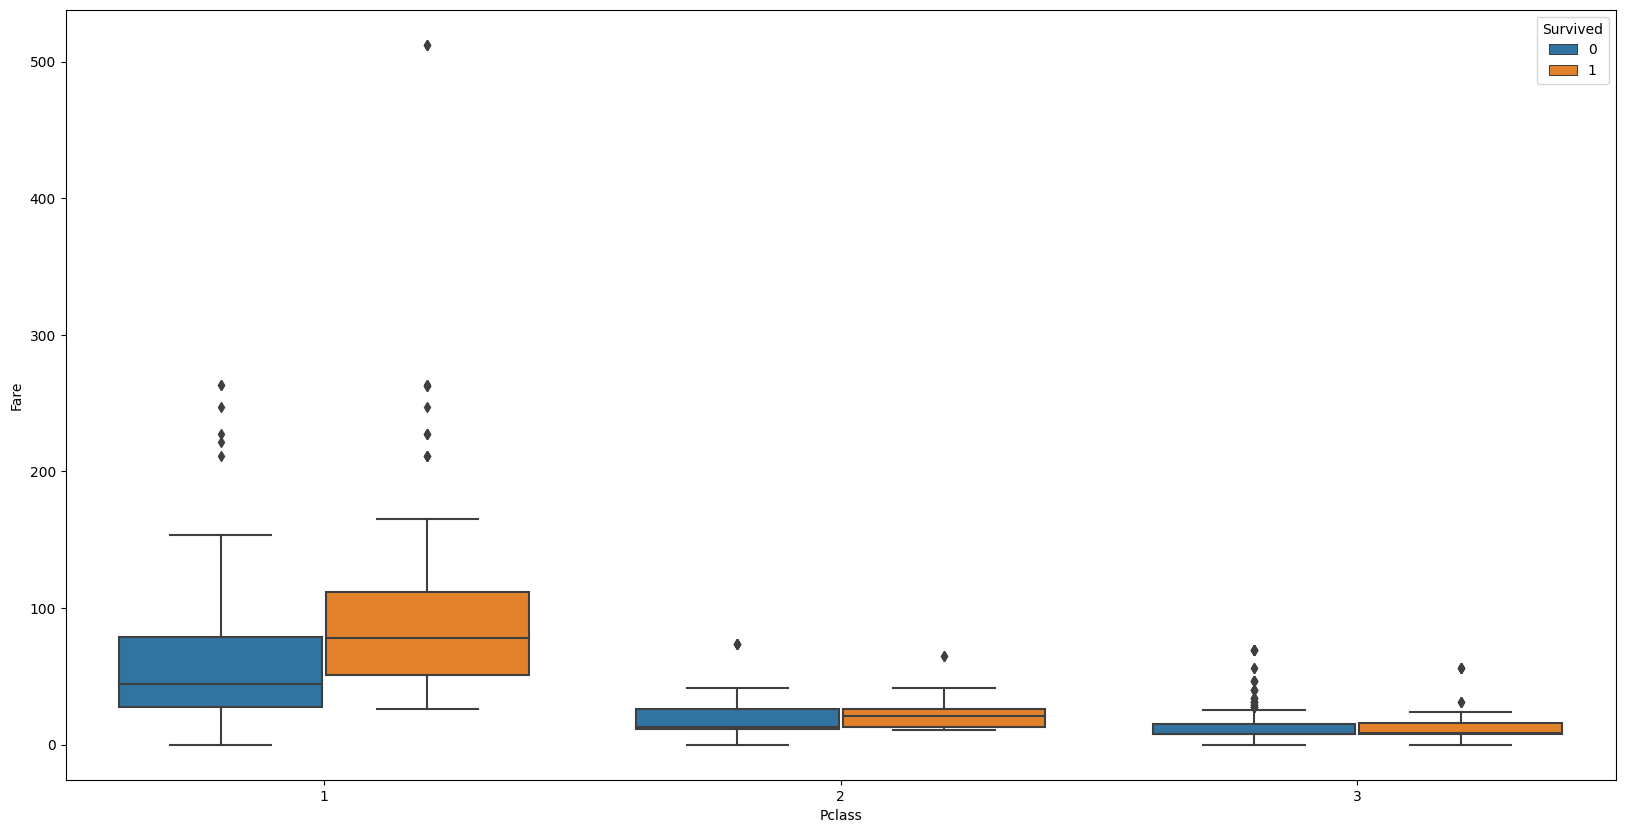

In [23]:
sns.boxplot(x="Pclass", y="Fare", hue="Survived", data=df)

Those, who have paid for the ticket more, have a higher probability of survival

In [24]:
df.corr().loc["Pclass", "Fare"]

-0.5494996199439076

Not surprisingly, they are strongly correlated, though there still seems to be some additional structure explained by `Fare`

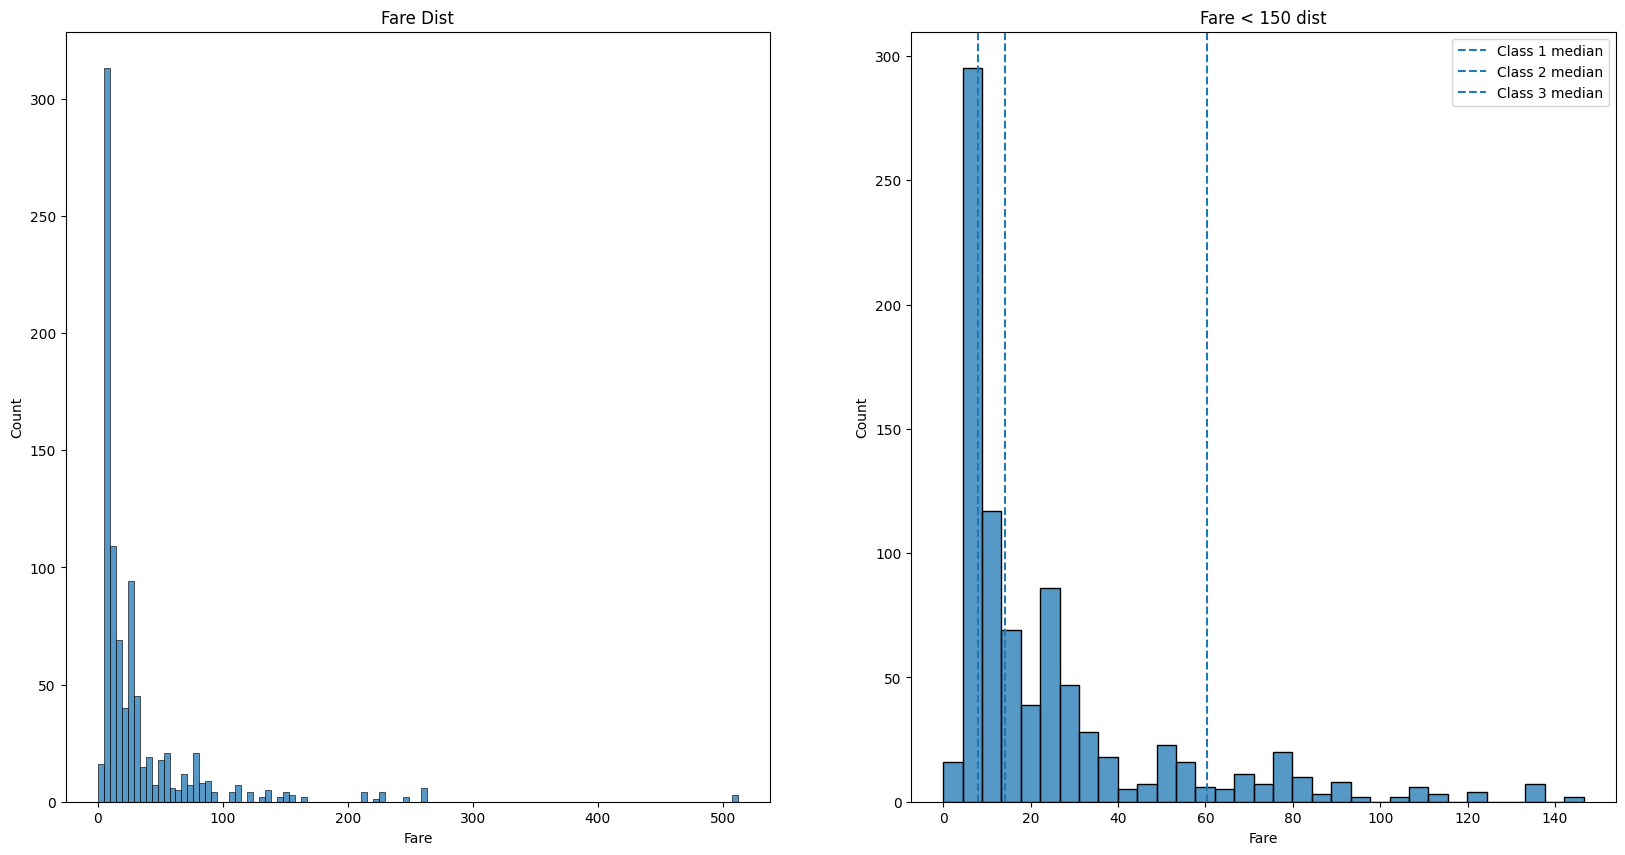

In [25]:
f, (ax1, ax2) = plt.subplots(1, 2)
sns.histplot(x="Fare", data=df, ax=ax1)
ax1.set_title("Fare Dist")
sns.histplot(x="Fare", data=df[df["Fare"] < 150], ax=ax2)
ax2.set_title("Fare < 150 dist")

for claz in df["Pclass"].value_counts().index.sort_values():
    ax2.axvline(
        df.loc[df["Pclass"] == claz, "Fare"].median(), 
        label="Class " + str(claz) + " median",
        ls='--'
    )
ax2.legend()

In [26]:
median_3 = df.loc[df["Pclass"] == 3, "Fare"].median()
median_2 = df.loc[df["Pclass"] == 2, "Fare"].median()
median_1 = df.loc[df["Pclass"] == 1, "Fare"].median()

df["fare_cat"] = pd.cut(
    df["Fare"], [0, median_3, median_2, median_1, np.inf], 
    right=False, labels=["<med3", "[med3;med2]", "[med2;med1]", ">med1"]
    
)
survived_summary("fare_cat")

Survived            
               count  sum  ratio
fare_cat                        
<med3            242   53  21.9%
[med3;med2]      196   58  29.6%
[med2;med1]      331  149  45.0%
>med1            122   82  67.2%

This supports the conclusion previously observed: the more you'd paid for the ticket, the more the prob of survival. </br>
However, there is still left a posibility of this information already being represented by `Pclass`.

In [27]:
survived_summary(["Pclass", "fare_cat"])

Survived           
                      count sum  ratio
Pclass fare_cat                       
1      <med3              6   0   0.0%
       [med3;med2]        0   0   nan%
       [med2;med1]      102  56  54.9%
       >med1            108  80  74.1%
2      <med3              6   0   0.0%
       [med3;med2]       86  33  38.4%
       [med2;med1]       85  52  61.2%
       >med1              7   2  28.6%
3      <med3            230  53  23.0%
       [med3;med2]      110  25  22.7%
       [med2;med1]      144  41  28.5%
       >med1              7   0   0.0%

This reduces such a possibility: no matter what class you're in, if you've paid more then the median val, you are more likely to survive.</br>
Though the magnitude of this "more likely" is class-dependent

### Embarked

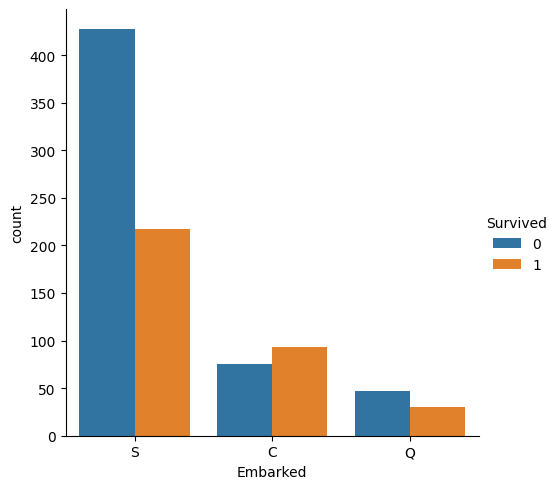

In [28]:
sns.catplot(data=df, x="Embarked", hue="Survived", kind="count")

In [29]:
survived_summary(["Embarked"])

Survived            
            count  sum  ratio
Embarked                     
C             168   93  55.4%
Q              77   30  39.0%
S             644  217  33.7%

In [30]:
survived_summary(["Pclass", "Embarked"])

Survived           
                   count sum  ratio
Pclass Embarked                    
1      C              85  59  69.4%
       Q               2   1  50.0%
       S             127  74  58.3%
2      C              17   9  52.9%
       Q               3   2  66.7%
       S             164  76  46.3%
3      C              66  25  37.9%
       Q              72  27  37.5%
       S             353  67  19.0%

In [31]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df["Cabin"].value_counts())

B96 B98            4
G6                 4
C23 C25 C27        4
C22 C26            3
F33                3
F2                 3
E101               3
D                  3
C78                2
C93                2
E8                 2
D36                2
B77                2
C123               2
E121               2
E44                2
D35                2
C125               2
E67                2
B35                2
B18                2
E24                2
B49                2
C65                2
B20                2
B5                 2
B57 B59 B63 B66    2
C126               2
B51 B53 B55        2
F4                 2
C124               2
F G73              2
B58 B60            2
C52                2
D33                2
C68                2
D20                2
D26                2
B28                2
C83                2
E25                2
D17                2
B22                2
C92                2
C2                 2
E33                2
C70                1
E58          

### Deck
Inspection of the value_counts has shown that it is sufficient to take the first letter of the `Cabin`

In [32]:
df["Deck"] = df["Cabin"].str.slice(0, 1)
df["Deck"].value_counts()

C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: Deck, dtype: int64

<AxesSubplot:xlabel='Deck', ylabel='count'>

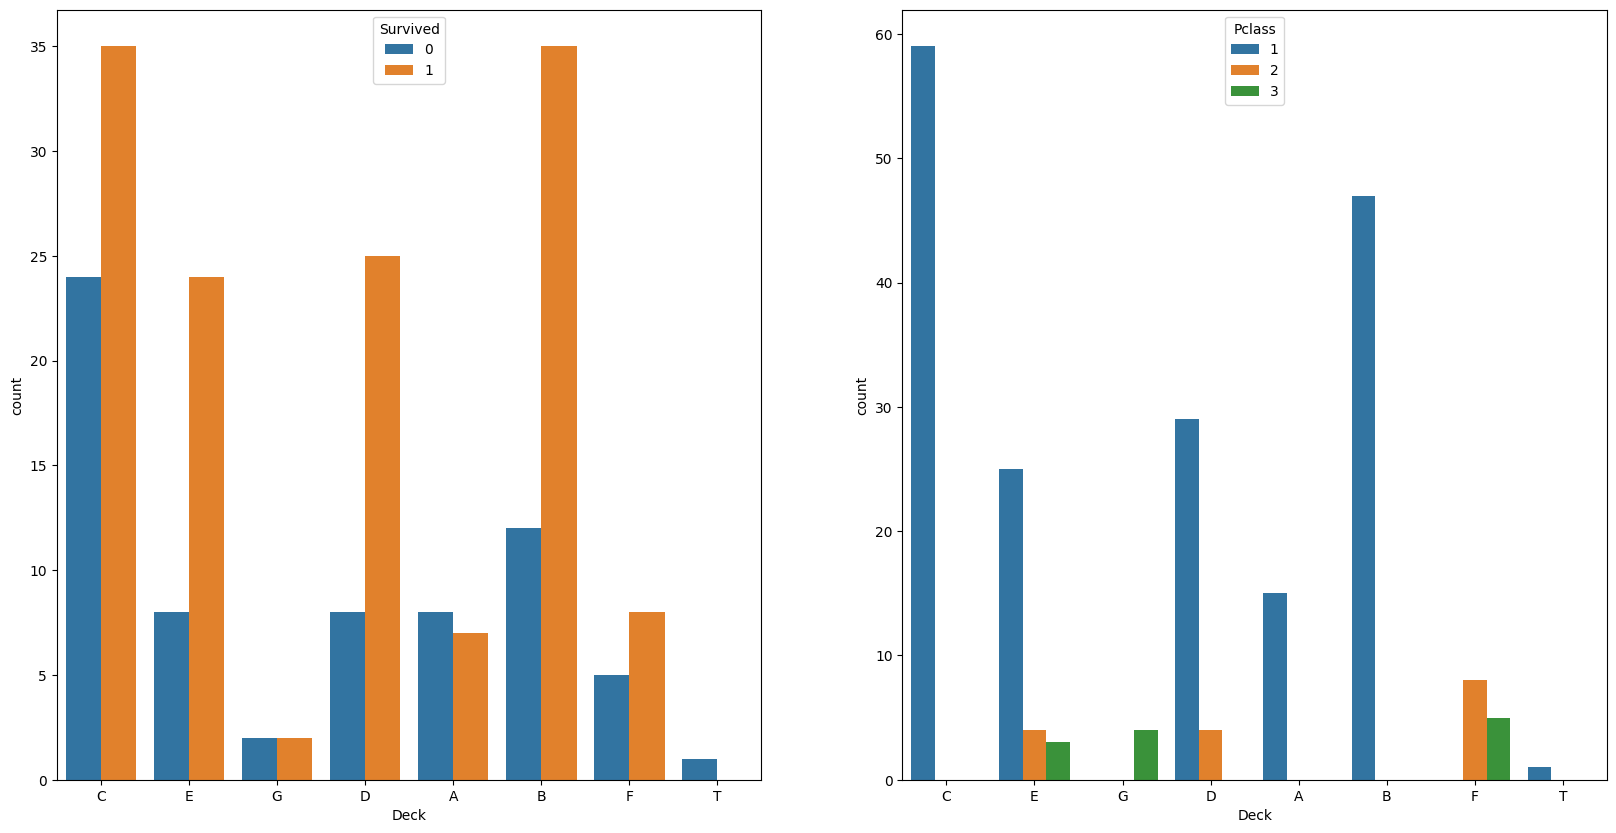

In [33]:
f, (ax1, ax2) = plt.subplots(1, 2)
sns.countplot(data=df, x="Deck", hue="Survived", ax=ax1)
sns.countplot(data=df, x="Deck", hue="Pclass", ax=ax2)

In [34]:
survived_summary(["Deck"])

Survived           
        count sum  ratio
Deck                    
A          15   7  46.7%
B          47  35  74.5%
C          59  35  59.3%
D          33  25  75.8%
E          32  24  75.0%
F          13   8  61.5%
G           4   2  50.0%
T           1   0   0.0%

It would seems as though the deck plays a key part here, but adjusting by the `Pclass`:

In [35]:
survived_summary(["Pclass", "Deck"])

Survived            
               count sum   ratio
Pclass Deck                     
1      A          15   7   46.7%
       B          47  35   74.5%
       C          59  35   59.3%
       D          29  22   75.9%
       E          25  18   72.0%
       T           1   0    0.0%
2      D           4   3   75.0%
       E           4   3   75.0%
       F           8   7   87.5%
3      E           3   3  100.0%
       F           5   1   20.0%
       G           4   2   50.0%

We see the problem here: `Cabin` and therefore `Deck` were not recorded for almost all of the `2-3` class passengers. </br>
Nonetheless we see that it plays an important role among the 1-class passengers

## Summary
Variables not mentioned -- `Ticket` and `Name` -- does not seem to be related to the response. </br>


### Notes on  imputing `Age`
Simple imputing here is no good option -- `Age` can clearly be deduced from other predictors. </br>
As an example, here is a clear relationship between `Pclass` and `Age`:

In [36]:
palette=[
    "tab:blue", "tab:orange", 
    "tab:green", "tab:red", 
    "tab:grey", "tab:purple", "tab:brown",
    "tab:pink",
    "tab:olive",
    "tab:cyan"
]

def plot_age_kde_wmed(
    *,
    hue, 
    ax,
    palette=palette,
):
    # credit: https://stackoverflow.com/questions/28956622/how-to-locate-the-median-in-a-seaborn-kde-plot
    # it doesn't work with hue (lines are messed up), 
    # so what follows is a homemade hue implementation:
    for i, val in enumerate(
        df[hue].value_counts().index.sort_values(),
    ):
        p=sns.kdeplot(
            x=df.loc[df[hue] == val, "Age"], 
            color=palette[i], ax=ax, 
            label=hue + " " + str(val)
        )

        # credit
        x,y = p.get_lines()[i].get_data()
        cdf = sp.integrate.cumtrapz(y, x, initial=0)
        nearest_05 = np.abs(cdf-0.5).argmin()
        x_median = x[nearest_05]
        y_median = y[nearest_05]
        ax.vlines(x_median, 0, y_median, color=palette[i], ls='--', label="median")


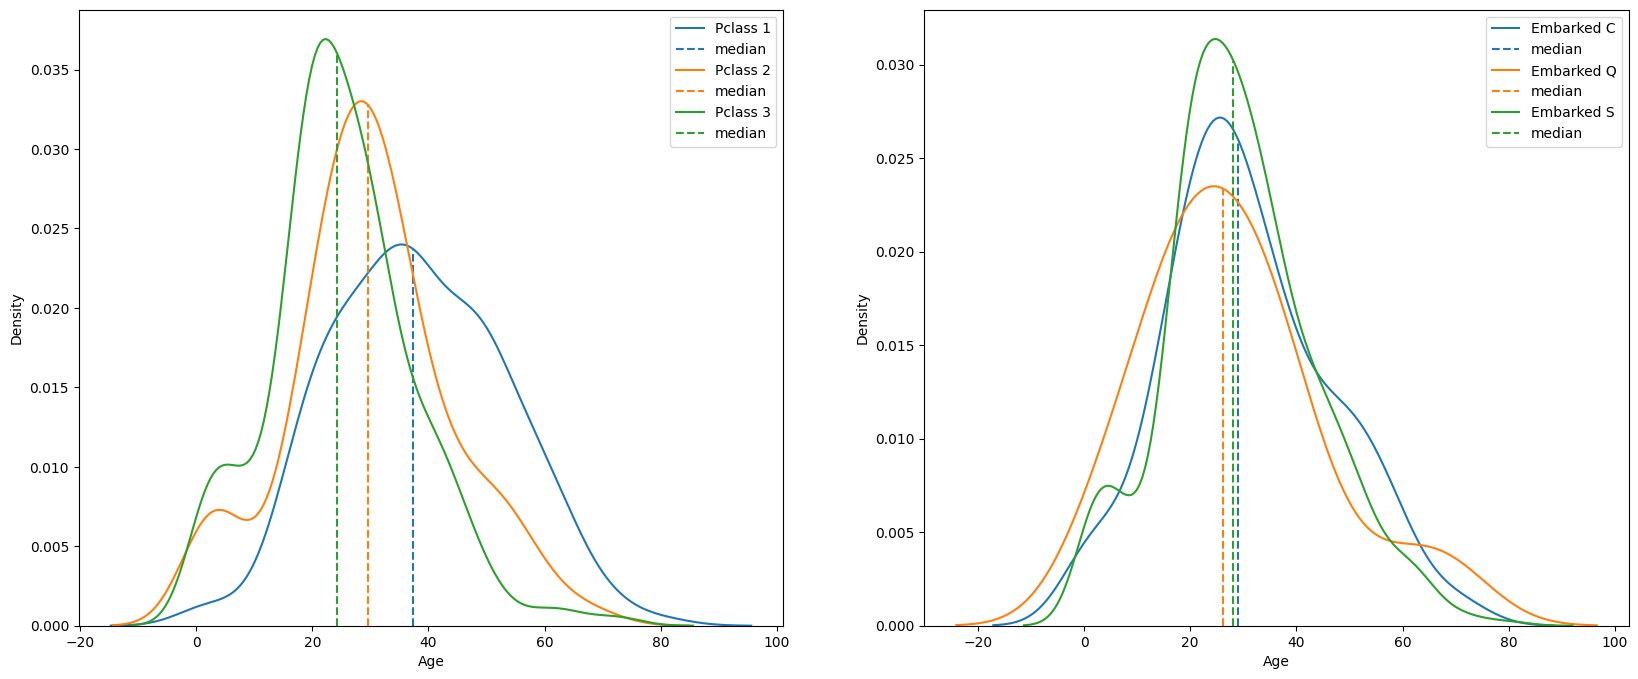

In [37]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))


plot_age_kde_wmed(
    hue="Pclass", ax=ax1, 
)

plot_age_kde_wmed(
    hue="Embarked", ax=ax2, 
)
    
ax1.legend()
ax2.legend()

# Pipeline

In [38]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin


class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    DECK_COL = "deck"

    def __init__(self, add_deck=True):
        self.add_deck = add_deck

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        res = pd.DataFrame(
            np.empty(
                (X.shape[0],0)
            ),
            index=X.index
        )
        if self.add_deck:
            res[self.DECK_COL] = X["Cabin"].str.slice(0, 1)
        return res
    
    def get_feature_names_out(self, *args, **kwargs):
        res = []
        if self.add_deck:
            res.append(self.DECK_COL)
        return res

For the following code, some notes:
- `SibSp` and `Parch` are OHEncoded, and not OrdEncoded, since as EDA has shown, there is no obvious "bigger->better" relationship there; there is another reason:
- We'd like to later include the interactions between different `PClass`, `SibSp` and `Parch` categories. For this reason also `Pclass` is OHEncoded, whereas one might think ordinal encoding is also suitable.
- Note that imputing is not performed somewhere in `ColumnTransformer`, but on the whole dataset later on. Reason was mentioned earlier: we will try to use `IterativeImputer`, and `KNNImputer` to deduce `Age` from other columns.
- Note that feature selection step is performed after including polynomial interactions.
- Reason why `model` and `transform` pipelines are separated is that we might use transformation separately, e.g. conducting diagnostics on LogisticRegression with `statsmodels` later.

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE

cat_vars = ["Sex", "Embarked", "SibSp", "Parch", "Pclass"]
num_vars = ["Age", "Fare"]

ohe = OneHotEncoder(
    # o.w. the data matrix is singular
    drop="first",
    handle_unknown="ignore",
    # o.w. raises error
    sparse=False,
)

enc_pipeline = ColumnTransformer([
    ("num", MinMaxScaler(), num_vars),
    ("cat", ohe, cat_vars),
    ("adder", make_pipeline(CombinedAttributesAdder(), ohe), ["Cabin"]),
], remainder="drop")

fe_pipeline = Pipeline([
    ("pol", PolynomialFeatures(
        include_bias=False, interaction_only=True)
    ),
    ("select", RFE(LogisticRegression()))
])

transform_pipeline = Pipeline([
    ("enc", enc_pipeline),
    ("impute", SimpleImputer()),
    ("fe", fe_pipeline),
])

model_pipeline = Pipeline([("ts", transform_pipeline),
                           ("clf", LogisticRegression())])

In [40]:
model_pipeline

Pipeline(steps=[('ts',
                 Pipeline(steps=[('enc',
                                  ColumnTransformer(transformers=[('num',
                                                                   MinMaxScaler(),
                                                                   ['Age',
                                                                    'Fare']),
                                                                  ('cat',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False),
                                                                   ['Sex',
                                                                    'Embarked',
                                                                    'SibSp',
                                                                    'Parch',
                                                                    'Pclass']),
                                                                  ('adder',
                                                                   Pipeline(steps=[('combinedattributesadder',
                                                                                    CombinedAttributesAdder()),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(drop='first',
                                                                                                  handle_unknown='ignore',
                                                                                                  sparse=False))]),
                                                                   ['Cabin'])])),
                                 ('impute', SimpleImputer()),
                                 ('fe',
                                  Pipeline(steps=[('pol',
                                                   PolynomialFeatures(include_bias=False,
                                                                      interaction_only=True)),
                                                  ('select',
                                                   RFE(estimator=LogisticRegression()))]))])),
                ('clf', LogisticRegression())])

Test of transformation

In [41]:
trans = transform_pipeline.fit(X, y)
df_tr = pd.DataFrame(
    trans.transform(X), 
    columns=trans.get_feature_names_out(),
    index=X.index
)
df_tr

,num__Age,num__Fare,cat__Sex_male,cat__Embarked_S,cat__Embarked_nan,cat__SibSp_1,cat__SibSp_2,cat__SibSp_3,cat__SibSp_4,cat__SibSp_5,...,cat__Parch_6 cat__Pclass_3,cat__Parch_6 adder__deck_nan,cat__Pclass_2 adder__deck_D,cat__Pclass_2 adder__deck_E,cat__Pclass_2 adder__deck_F,cat__Pclass_2 adder__deck_nan,cat__Pclass_3 adder__deck_E,cat__Pclass_3 adder__deck_F,cat__Pclass_3 adder__deck_G,cat__Pclass_3 adder__deck_nan
0,0.271174,0.014151,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.472229,0.139136,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.321438,0.015469,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.434531,0.103644,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.434531,0.015713,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.334004,0.025374,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
887,0.233476,0.058556,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
888,0.367921,0.045771,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
889,0.321438,0.058556,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Useful when constructing `param_grid`

In [42]:
model_pipeline.get_params()

{'memory': None,
 'steps': [('ts', Pipeline(steps=[('enc',
                    ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                     ['Age', 'Fare']),
                                                    ('cat',
                                                     OneHotEncoder(drop='first',
                                                                   handle_unknown='ignore',
                                                                   sparse=False),
                                                     ['Sex', 'Embarked', 'SibSp',
                                                      'Parch', 'Pclass']),
                                                    ('adder',
                                                     Pipeline(steps=[('combinedattributesadder',
                                                                      CombinedAttributesAdder()),
                                                                 

In [44]:
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from scipy.stats import uniform, gamma, binom
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA


main_params = {
    "ts__enc__adder__combinedattributesadder__add_deck": [True, False],
}

pol_params = [
    {
        'ts__fe__pol__interaction_only': [True, False],
        "ts__fe__select__n_features_to_select": [10, 20, 30, 50, 100, 200]
    },
    {
        'ts__fe__pol': ["passthrough"],
        "ts__fe__select": ["passthrough"]
    }
]
imp_params = [
    {
        "ts__impute": [SimpleImputer()],
        "ts__impute__strategy": ["median"],
    },
    {
        "ts__impute": [IterativeImputer()],
        "ts__impute__estimator": [
            # default
            BayesianRidge(),
            # todo: what else to add?
        ],
    },
    {
        "ts__impute": [KNNImputer()],
        "ts__impute__n_neighbors": [3, 5, 10],
    },
]

clf_params = [
    {
        "clf": [KNeighborsClassifier()],
        "clf__n_neighbors": [3, 5, 7, 10, 15],
        "clf__weights": ["uniform", "distance"]
    },
    {
        "clf": [RandomForestClassifier()],
        "clf__n_estimators": [50, 100, 200, 400],
        "clf__max_depth": [25, 50, 100],
    },
    {
        "clf": [SVC()],
        "clf__C": gamma(a=3.0),
        "clf__kernel": ["linear", "poly", "rbf", "sigmoid"],
    },
    {
        "clf": [SVC()],
        "clf__C": gamma(a=3.0),
        "clf__kernel": ["linear", "poly", "rbf", "sigmoid"],
    },
    
]

import itertools

grid_params = [{
    **main_params,
    **imp_i_params,
    **clf_i_params,
    **pol_i_params
} for imp_i_params, pol_i_params, clf_i_params in itertools.product(imp_params, clf_params, pol_params)]

In [45]:
import pickle
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

GS_RES_FILE_NAME = "gs.pkl"
try:
    gs_file = open(GS_RES_FILE_NAME, 'rb')
    gs = pickle.load(gs_file)
except FileNotFoundError:
    gs = RandomizedSearchCV(
        model_pipeline, grid_params, 
        random_state=42,
        n_iter=500,
        cv=10,
        verbose=2,
        error_score='raise',
        scoring=["accuracy", "recall", "precision"],
        refit="accuracy",
        n_jobs=4,
    ).fit(X, y)

    gs_file = open(GS_RES_FILE_NAME, 'wb')
    pickle.dump(gs, gs_file)

In [46]:
gs.best_score_, gs.best_params_

(0.8249563046192259,
 {'clf': LogisticRegression(C=3.1861719474409314),
  'clf__C': 3.1861719474409314,
  'ts__enc__adder__combinedattributesadder__add_deck': True,
  'ts__enc__adder__combinedattributesadder__add_nationality': False,
  'ts__fe__pol__interaction_only': True,
  'ts__fe__select__n_features_to_select': 100,
  'ts__impute': SimpleImputer(strategy='median'),
  'ts__impute__strategy': 'median'})

In [47]:
gs.score(X, y)

0.856341189674523

## Boosting
I use a separate GS for boosting, because chances are it is going to perform the best. </br>
Reasons for this:
- As EDA has shown, iteractions here do matter. Moreover, Gradient Boosting does a better job of including those interactions in the resulting model than our `fe_pipeline`. Reason: `RFE` in `fe_pipeline` does not quite succeed at selecting variables   

In [79]:
from sklearn.ensemble import GradientBoostingClassifier

boost_clf_params = [
    {
        "clf": [GradientBoostingClassifier()],
        "clf__learning_rate": [0.1],
        "clf__n_estimators": [50, 100, 200, 300],
        "clf__subsample": [1, 0.5],
        "clf__max_depth": [2, 3, 6],
        "clf__n_iter_no_change": [None, 5],
    },
]
boost_pol_params = [
    {
        'ts__fe__pol': ["passthrough"],
        "ts__fe__select": ["passthrough"]
    }
]


boosting_grid_params = [{
    **main_params,
    **imp_i_params,
    **clf_i_params,
    **pol_i_params
} for imp_i_params, pol_i_params, clf_i_params in 
    itertools.product(imp_params, boost_pol_params, boost_clf_params)]

In [81]:
BOOSTING_GS_RES_FILE_NAME = "boosting_gs.pkl"
try:
    gs_file = open(BOOSTING_GS_RES_FILE_NAME, 'rb')
    boost_gs = pickle.load(gs_file)
except FileNotFoundError:
    boost_gs = GridSearchCV(
        model_pipeline, boosting_grid_params, 
#         random_state=42,
#         n_iter=500,
        cv=10,
        verbose=2,
        error_score='raise',
        scoring=["accuracy", "recall", "precision"],
        refit="accuracy",
        n_jobs=4,
    ).fit(X, y)

    gs_file = open(GS_RES_FILE_NAME, 'wb')
    pickle.dump(boost_gs, gs_file)

Fitting 10 folds for each of 480 candidates, totalling 4800 fits


In [82]:
boost_gs.best_score_, boost_gs.best_params_

(0.8395380774032459,
 {'clf': GradientBoostingClassifier(max_depth=2, n_estimators=200, subsample=0.5),
  'clf__learning_rate': 0.1,
  'clf__max_depth': 2,
  'clf__n_estimators': 200,
  'clf__n_iter_no_change': None,
  'clf__subsample': 0.5,
  'ts__enc__adder__combinedattributesadder__add_deck': True,
  'ts__fe__pol': 'passthrough',
  'ts__fe__select': 'passthrough',
  'ts__impute': SimpleImputer(strategy='median'),
  'ts__impute__strategy': 'median'})

In [83]:
boost_gs.score(X, y)

0.8843995510662177

<AxesSubplot:ylabel='Count'>

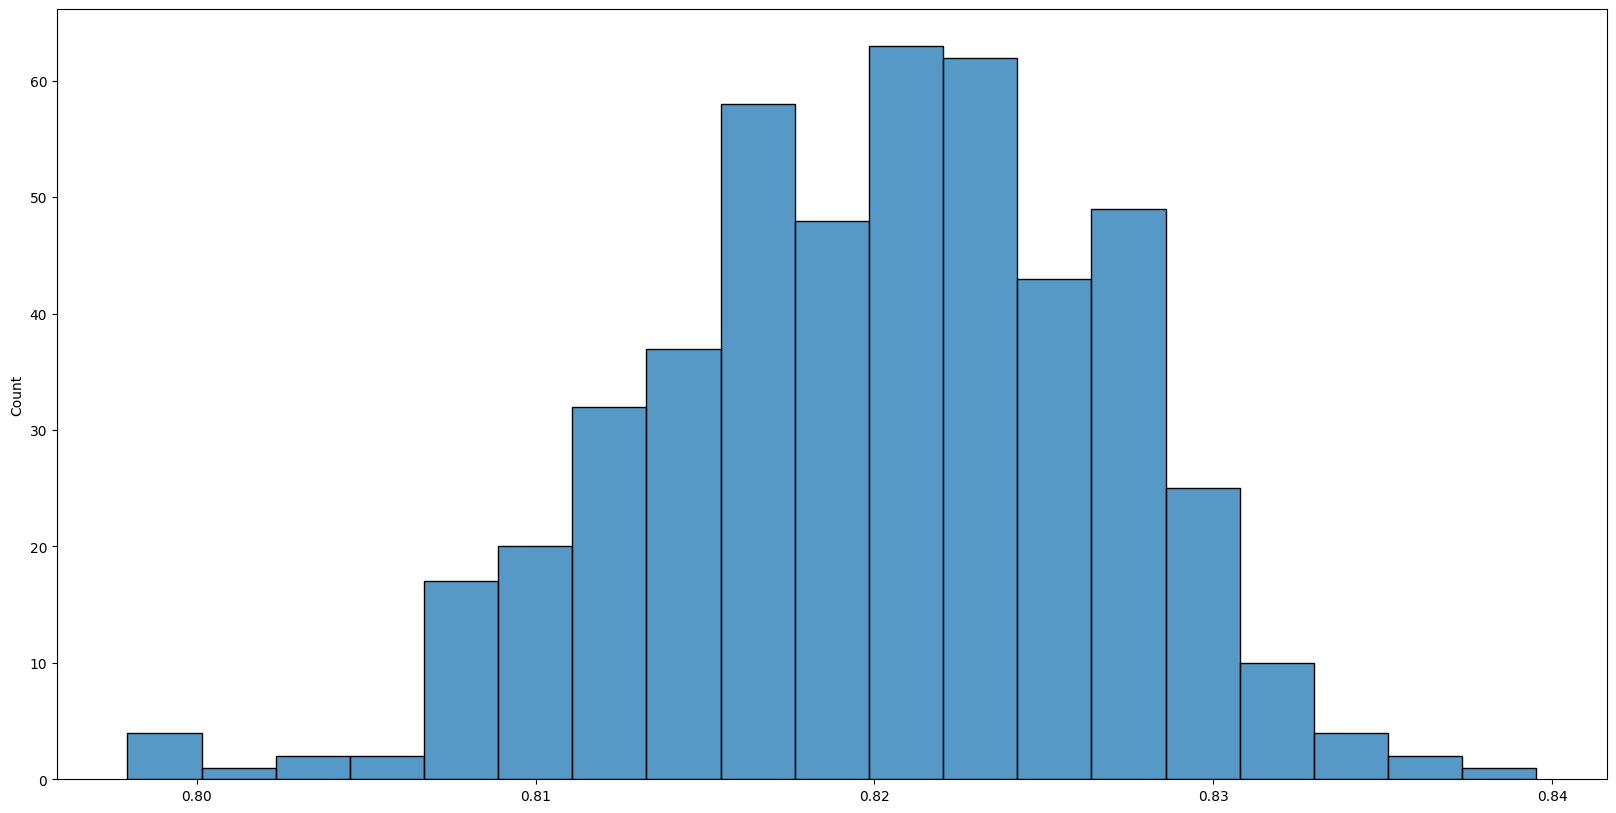

In [93]:
sns.histplot(x=boost_gs.cv_results_["mean_test_accuracy"])

Text(0.5, 0, 'Importance')

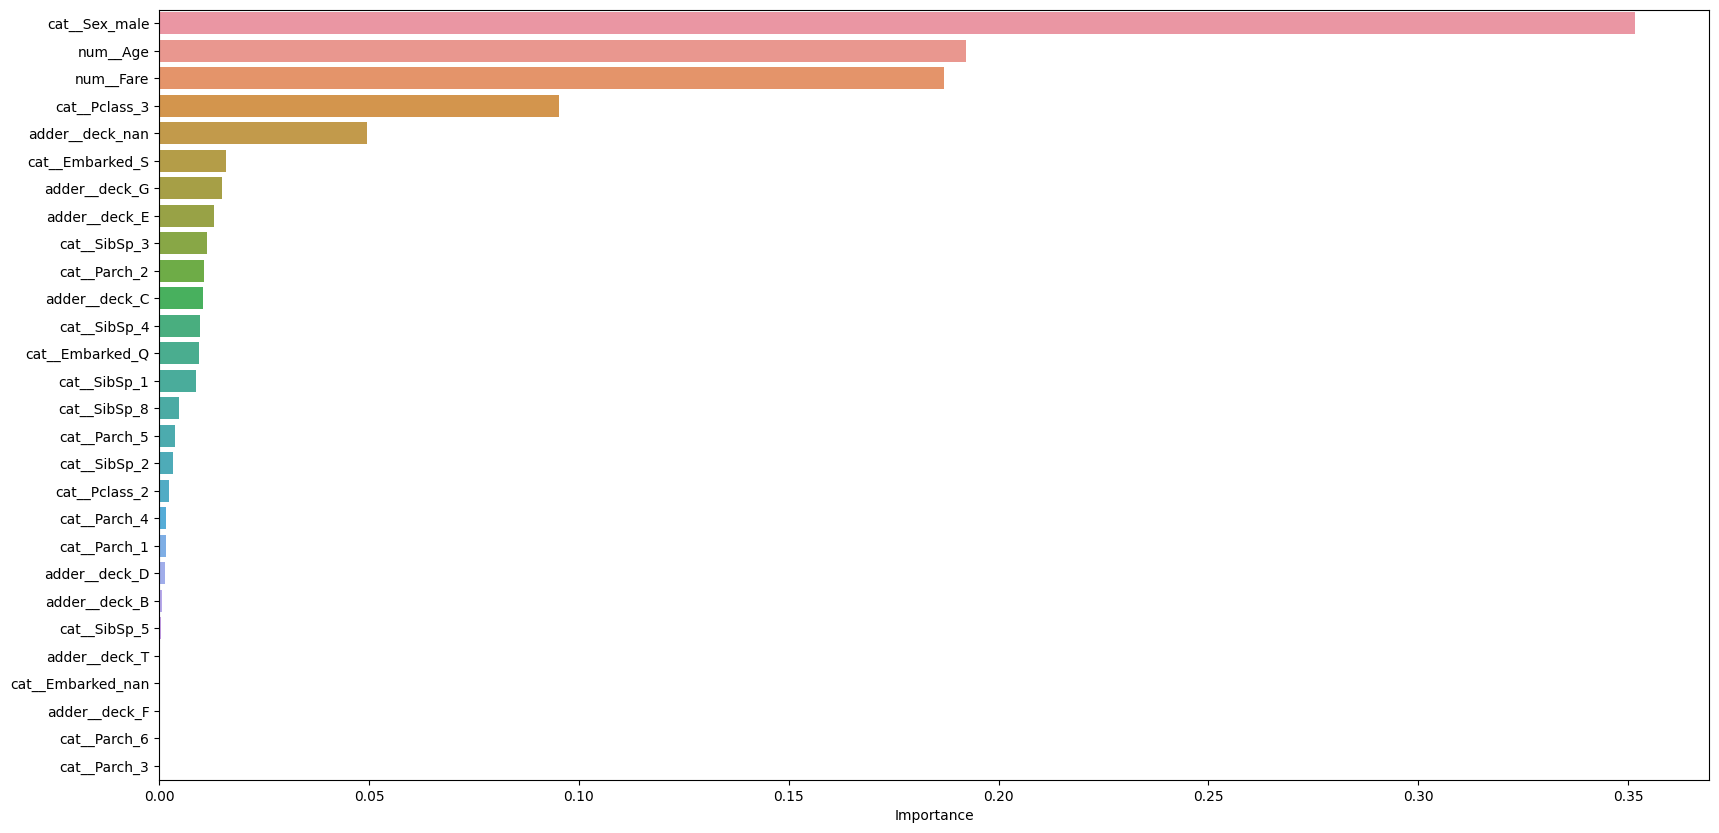

In [109]:
bs = boost_gs.best_estimator_
features=bs[:-1].get_feature_names_out()
importances = pd.Series(
    bs[-1].feature_importances_,
    index=features
).sort_values(ascending=False)

sns.barplot(x=importances, y=importances.index)
plt.gca().set_xlabel("Importance")


In [115]:
important_features = [0, 1, 2, ]
pd.DataFrame(bs[:-1].transform(X), columns=features)

,num__Age,num__Fare,cat__Sex_male,cat__Embarked_Q,cat__Embarked_S,cat__Embarked_nan,cat__SibSp_1,cat__SibSp_2,cat__SibSp_3,cat__SibSp_4,...,cat__Pclass_2,cat__Pclass_3,adder__deck_B,adder__deck_C,adder__deck_D,adder__deck_E,adder__deck_F,adder__deck_G,adder__deck_T,adder__deck_nan
0,0.271174,0.014151,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.472229,0.139136,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.321438,0.015469,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.434531,0.103644,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.434531,0.015713,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.334004,0.025374,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
887,0.233476,0.058556,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
888,0.346569,0.045771,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
889,0.321438,0.058556,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [119]:
X_tr2 = pd.DataFrame(bs[:-1].transform(X), columns=features)
X_tr2

,num__Age,num__Fare,cat__Sex_male,cat__Embarked_Q,cat__Embarked_S,cat__Embarked_nan,cat__SibSp_1,cat__SibSp_2,cat__SibSp_3,cat__SibSp_4,...,cat__Pclass_2,cat__Pclass_3,adder__deck_B,adder__deck_C,adder__deck_D,adder__deck_E,adder__deck_F,adder__deck_G,adder__deck_T,adder__deck_nan
0,0.271174,0.014151,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.472229,0.139136,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.321438,0.015469,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.434531,0.103644,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.434531,0.015713,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.334004,0.025374,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
887,0.233476,0.058556,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
888,0.346569,0.045771,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
889,0.321438,0.058556,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


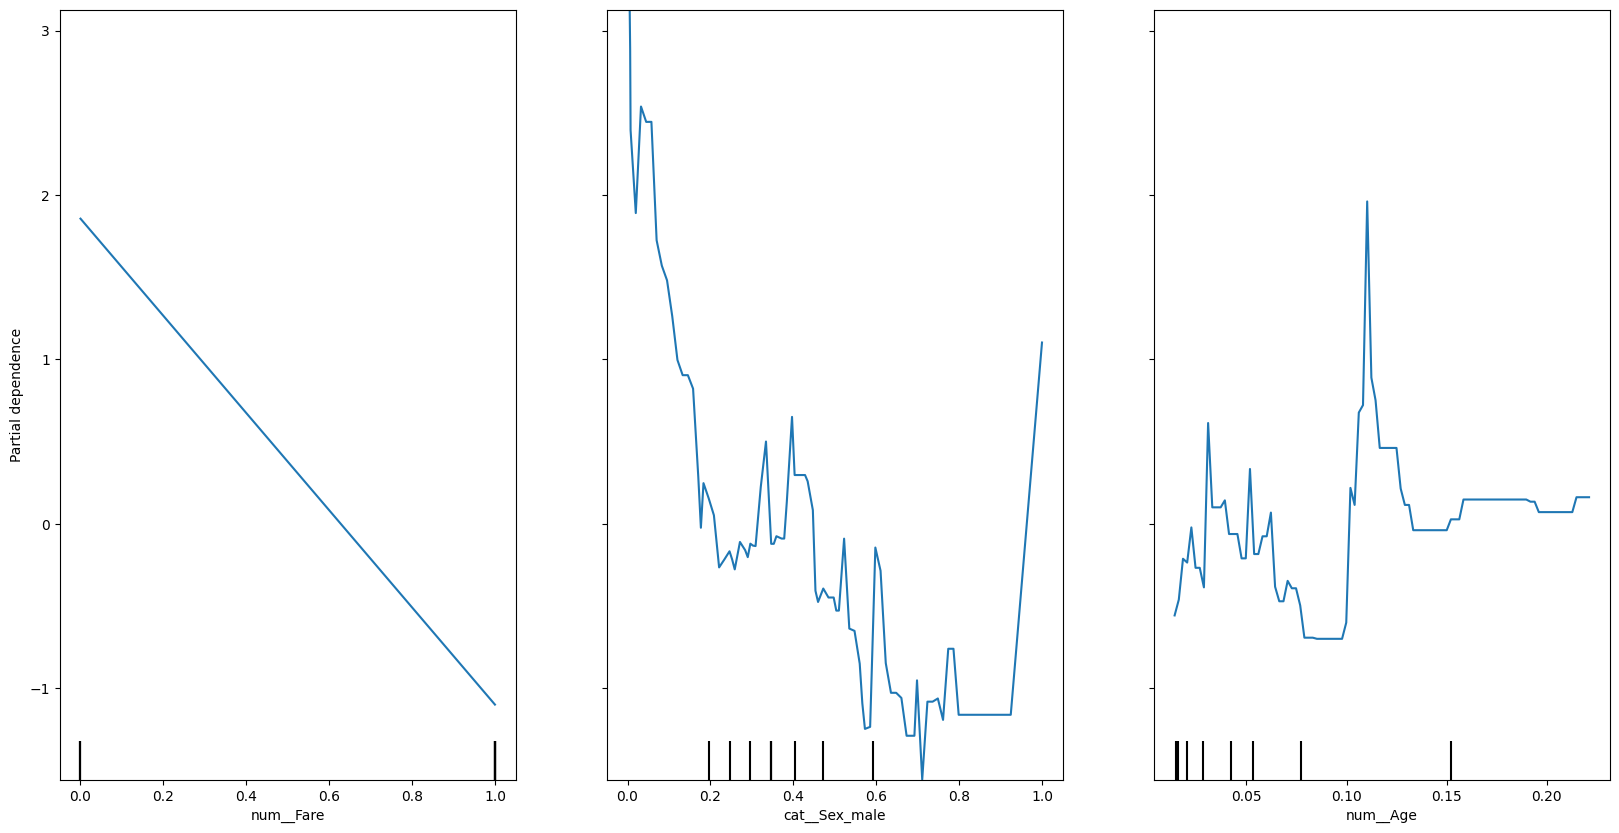

In [131]:
from sklearn.inspection import PartialDependenceDisplay

features_i = [
    X_tr2.columns.get_loc(feature_name)
    for feature_name in importances.index[:3]
]
    
PartialDependenceDisplay.from_estimator(
    bs[-1], X_tr2, 
    features_i, 
    feature_names=importances.index[:3]
)

In [132]:
features_i, importances.index[:3]

([2, 0, 1], Index(['cat__Sex_male', 'num__Age', 'num__Fare'], dtype='object'))

## Interpreting GridSearch results

In [48]:
def gs_summary(gs):
    columns = [
        "n",
        "mean_accuracy", "std_accuracy",
        "mean_recall", "std_recall",
        "mean_precision", "std_precision",
        "max_accuracy", "max_recall", "max_precision",
    ]
    additional_info = [
        "max_accuracy_params", "max_precision_params", "max_recall_params"
    ]
    cv_results = gs.cv_results_
    models_considered = cv_results["params"]
    n_iter = len(models_considered)
    
    d = {}
    for i in range(n_iter):
        model_i = models_considered[i]
        clf_i_name = type(model_i["clf"]).__name__
        
        if not clf_i_name in d:
            d[clf_i_name] = {col:0 for col in columns + additional_info}
            
        clf_i_entry = d[clf_i_name]
        clf_i_entry["n"] +=1
            
        # for the time being just add
        for summary, metric in itertools.product(
            ["mean"], ["accuracy", "recall", "precision"]
        ):
            clf_i_entry[summary + "_" + metric] += cv_results[summary + "_test_" + metric][i]
        
        # set max if required
        for maks, metric in itertools.product(
            ["max"], ["accuracy", "recall", "precision"]
        ):
            if cv_results["mean" + "_test_" +metric][i] > clf_i_entry[maks + "_" + metric]:
                clf_i_entry[maks + "_" + metric] = cv_results["mean" + "_test_" + metric][i]
                clf_i_entry[maks + "_" + metric + "_params"] = model_i
                
    for clf in d:
        for summary, metric in itertools.product(
            ["mean"], ["accuracy", "recall", "precision"]
        ):
            d[clf][summary + "_" + metric] /= d[clf]["n"]
            
#         for summary, metric in itertools.product(
#             ["std"], ["accuracy", "recall", "precision"]
#         ):
#             d[clf][summary + "_" + metric] /= d[clf]["mean"]
    
    res = pd.DataFrame(
        d.values(),
        index=d.keys()
    )
    return res

gs_summary(gs)

,n,mean_accuracy,std_accuracy,mean_recall,std_recall,mean_precision,std_precision,max_accuracy,max_recall,max_precision,max_accuracy_params,max_precision_params,max_recall_params
LogisticRegression,91,0.808516,0,0.691567,0,0.788069,0,0.824956,0.731345,0.872850,{'clf': LogisticRegression(C=3.186171947440931...,{'clf': LogisticRegression(C=3.186171947440931...,{'clf': LogisticRegression(C=3.186171947440931...
KNeighborsClassifier,99,0.788465,0,0.677120,0,0.752029,0,0.815993,0.725462,0.821449,"{'clf': KNeighborsClassifier(), 'clf__n_neighb...","{'clf': KNeighborsClassifier(), 'clf__n_neighb...","{'clf': KNeighborsClassifier(), 'clf__n_neighb..."
RandomForestClassifier,100,0.802861,0,0.719421,0,0.757251,0,0.818215,0.748235,0.789961,"{'clf': RandomForestClassifier(), 'clf__max_de...","{'clf': RandomForestClassifier(), 'clf__max_de...","{'clf': RandomForestClassifier(), 'clf__max_de..."
SVC,108,0.778528,0,0.650632,0,0.750096,0,0.814831,0.731092,0.873226,"{'clf': SVC(), 'clf__C': 1.773365141970839, 'c...","{'clf': SVC(), 'clf__C': 0.631999425321218, 'c...","{'clf': SVC(), 'clf__C': 3.020241806258583, 'c..."
DecisionTreeClassifier,102,0.802426,0,0.684068,0,0.778707,0,0.822734,0.728151,0.814137,"{'clf': DecisionTreeClassifier(), 'clf__max_de...","{'clf': DecisionTreeClassifier(), 'clf__max_de...","{'clf': DecisionTreeClassifier(), 'clf__max_de..."


<AxesSubplot:ylabel='Frequency'>

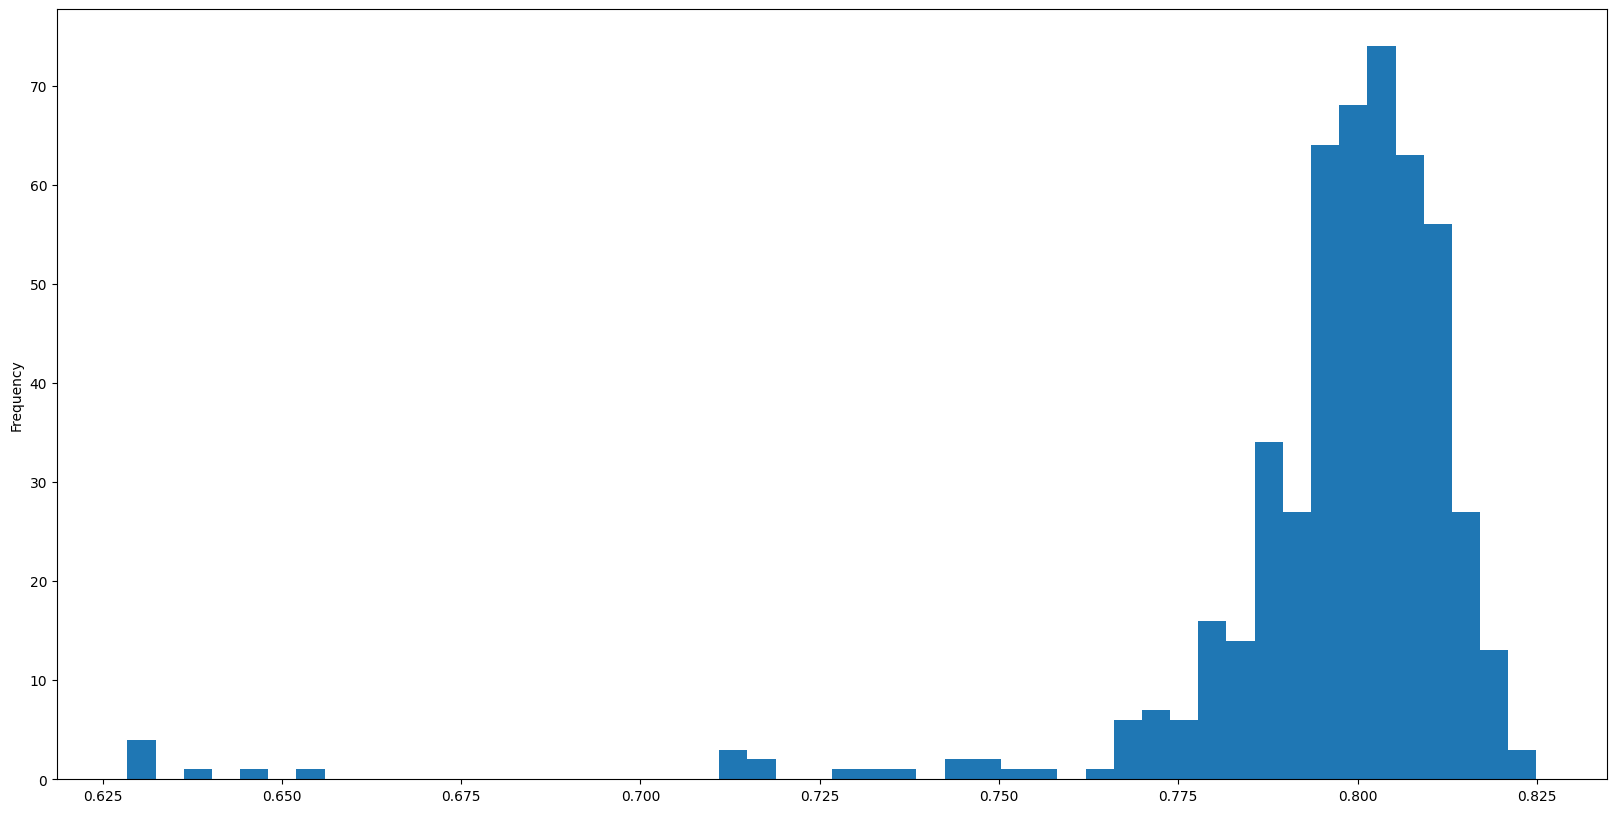

In [49]:
pd.Series(gs.cv_results_["mean_test_accuracy"]).plot(kind="hist", bins=50)

In [50]:
# exctracted from gs.best_params_
C = 3.18
params = {
    'enc__adder__combinedattributesadder__add_deck': True,
    'fe__pol__interaction_only': True,
    'fe__select__n_features_to_select': 100,
    'impute': SimpleImputer(strategy='median'),
    'impute__strategy': 'median'
}
transform_pipeline.set_params(**params)
X_tr = pd.DataFrame(
    transform_pipeline.fit_transform(X, y),
    columns=transform_pipeline.get_feature_names_out()
)
X_tr

,num__Age,num__Fare,cat__Sex_male,cat__Embarked_S,cat__SibSp_1,cat__SibSp_4,cat__SibSp_5,cat__SibSp_8,cat__Parch_4,cat__Parch_5,...,cat__Parch_5 cat__Pclass_3,cat__Parch_5 adder__deck_nan,cat__Parch_6 adder__deck_nan,cat__Pclass_2 adder__deck_D,cat__Pclass_2 adder__deck_E,cat__Pclass_2 adder__deck_F,cat__Pclass_3 adder__deck_E,cat__Pclass_3 adder__deck_F,cat__Pclass_3 adder__deck_G,cat__Pclass_3 adder__deck_nan
0,0.271174,0.014151,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.472229,0.139136,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.321438,0.015469,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.434531,0.103644,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.434531,0.015713,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.334004,0.025374,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
887,0.233476,0.058556,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
888,0.346569,0.045771,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
889,0.321438,0.058556,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
lr = LogisticRegression(C=C).fit(X_tr, y)
lr.score(X_tr, y)

0.856341189674523

In [52]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(pd.Series(lr.coef_[0], index=transform_pipeline.get_feature_names_out()).sort_values())

cat__Sex_male                     -2.865780
num__Age cat__Sex_male            -1.885614
num__Age cat__Parch_1             -1.667703
num__Age adder__deck_E            -1.601412
cat__Sex_male cat__Embarked_Q     -1.505553
cat__Embarked_Q cat__Parch_1      -1.368137
cat__Parch_1 adder__deck_G        -1.308743
cat__SibSp_3 cat__Parch_1         -1.304654
cat__Sex_male adder__deck_B       -1.256707
cat__Pclass_2 adder__deck_E       -1.245536
cat__Embarked_Q cat__Parch_2      -1.228319
num__Age cat__Parch_2             -1.206040
num__Age cat__Pclass_2            -1.175199
cat__SibSp_1 adder__deck_E        -1.171526
cat__Parch_2 adder__deck_C        -1.111482
cat__Pclass_3                     -1.036600
num__Age cat__Pclass_3            -1.021104
num__Age cat__SibSp_1             -1.004407
cat__Sex_male cat__SibSp_3        -0.950788
cat__SibSp_1 adder__deck_C        -0.938339
cat__SibSp_2 cat__Parch_2         -0.913693
cat__Sex_male adder__deck_F       -0.912958
cat__Sex_male cat__Pclass_2     

In [53]:
from statsmodels.tools.tools import add_constant

lmod = sm.Logit(y, add_constant(X_tr)).fit_regularized(
    start_params=np.concatenate([lr.intercept_, lr.coef_[0]]),
    alpha=0.1,
)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3615895861086722
            Iterations: 746
            Function evaluations: 746
            Gradient evaluations: 746


In [54]:
lmod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      808
Method:                           MLE   Df Model:                           82
Date:                Wed, 14 Sep 2022   Pseudo R-squ.:                  0.4419
Time:                        16:05:39   Log-Likelihood:                -331.14
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 1.089e-65
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               3.8584   5.52e+06   6.99e-07      1.000   -1.08e+07    1.08e+07
num__Age                                 0        nan        nan        nan         nan         nan
num__Fare                                0        nan        nan        nan         nan         nan
cat__Sex_male                      -3.4012        nan        nan        nan         nan         nan
cat__Embarked_S                    -0.2481        nan        nan        nan         nan         nan
cat__SibSp_1                        1.5356        nan        nan        nan         nan         nan
cat__SibSp_4                       -0.3233        nan        nan        nan         nan         nan
cat__SibSp_5                       -0.8435   1.66e+10  -5.07e-11      1.000   -3.26e+10    3.26e+10
cat__SibSp_8                       -0.7564   1.93e+08  -3.93e-09      1.000   -3.77e+08    3.77e+08
cat__Parch_4                       -1.5084        nan        nan        nan         nan         nan
cat__Parch_5                       -0.7830   1.13e+15  -6.92e-16      1.000   -2.22e+15    2.22e+15
cat__Pclass_3                      -1.3243      1.480     -0.895      0.371      -4.225       1.576
adder__deck_B                       1.7989        nan        nan        nan         nan         nan
adder__deck_D                       0.0217      0.899      0.024      0.981      -1.740       1.784
adder__deck_E                       8.7006      3.076      2.829      0.005       2.672      14.729
adder__deck_G                            0        nan        nan        nan         nan         nan
adder__deck_T                      -1.6547      3.406     -0.486      0.627      -8.330       5.021
adder__deck_nan                    -1.2943      1.641     -0.789      0.430      -4.510       1.921
num__Age num__Fare                  9.1754      6.526      1.406      0.160      -3.616      21.967
num__Age cat__Sex_male             -2.0088      0.600     -3.346      0.001      -3.186      -0.832
num__Age cat__SibSp_1              -1.9955      2.724     -0.732      0.464      -7.335       3.344
num__Age cat__Parch_1              -2.7430      5.068     -0.541      0.588     -12.677       7.191
num__Age cat__Parch_2              -2.1543        nan        nan        nan         nan         nan
num__Age cat__Pclass_2             -1.5248      2.636     -0.578      0.563      -6.691       3.642
num__Age cat__Pclass_3                   0        nan        nan        nan         nan         nan
num__Age adder__deck_E            -13.4071        nan        nan        nan         nan         nan
num__Age adder__deck_nan            0.7499      1.677      0.447      0.655      -2.537       4.037
num__Fare adder__deck_B                  0        nan        nan        nan         nan         nan
num__Fare adder__deck_C            -4.3273      4.536     -0.954      0.340     -13.218       4.564
cat__Sex_male cat__Embarked_Q      -1.946

In [55]:
from sklearn.metrics import accuracy_score
pred = lmod.predict(add_constant(X_tr))
pred = pred.apply(lambda x: 1 if x>0.5 else 0)
accuracy_score(y, pred)

0.8529741863075196

In [56]:
coefs = pd.Series(lr.coef_[0], index=X_tr.columns)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(coefs.sort_values())

cat__Sex_male                     -2.865780
num__Age cat__Sex_male            -1.885614
num__Age cat__Parch_1             -1.667703
num__Age adder__deck_E            -1.601412
cat__Sex_male cat__Embarked_Q     -1.505553
cat__Embarked_Q cat__Parch_1      -1.368137
cat__Parch_1 adder__deck_G        -1.308743
cat__SibSp_3 cat__Parch_1         -1.304654
cat__Sex_male adder__deck_B       -1.256707
cat__Pclass_2 adder__deck_E       -1.245536
cat__Embarked_Q cat__Parch_2      -1.228319
num__Age cat__Parch_2             -1.206040
num__Age cat__Pclass_2            -1.175199
cat__SibSp_1 adder__deck_E        -1.171526
cat__Parch_2 adder__deck_C        -1.111482
cat__Pclass_3                     -1.036600
num__Age cat__Pclass_3            -1.021104
num__Age cat__SibSp_1             -1.004407
cat__Sex_male cat__SibSp_3        -0.950788
cat__SibSp_1 adder__deck_C        -0.938339
cat__SibSp_2 cat__Parch_2         -0.913693
cat__Sex_male adder__deck_F       -0.912958
cat__Sex_male cat__Pclass_2     

<AxesSubplot:>

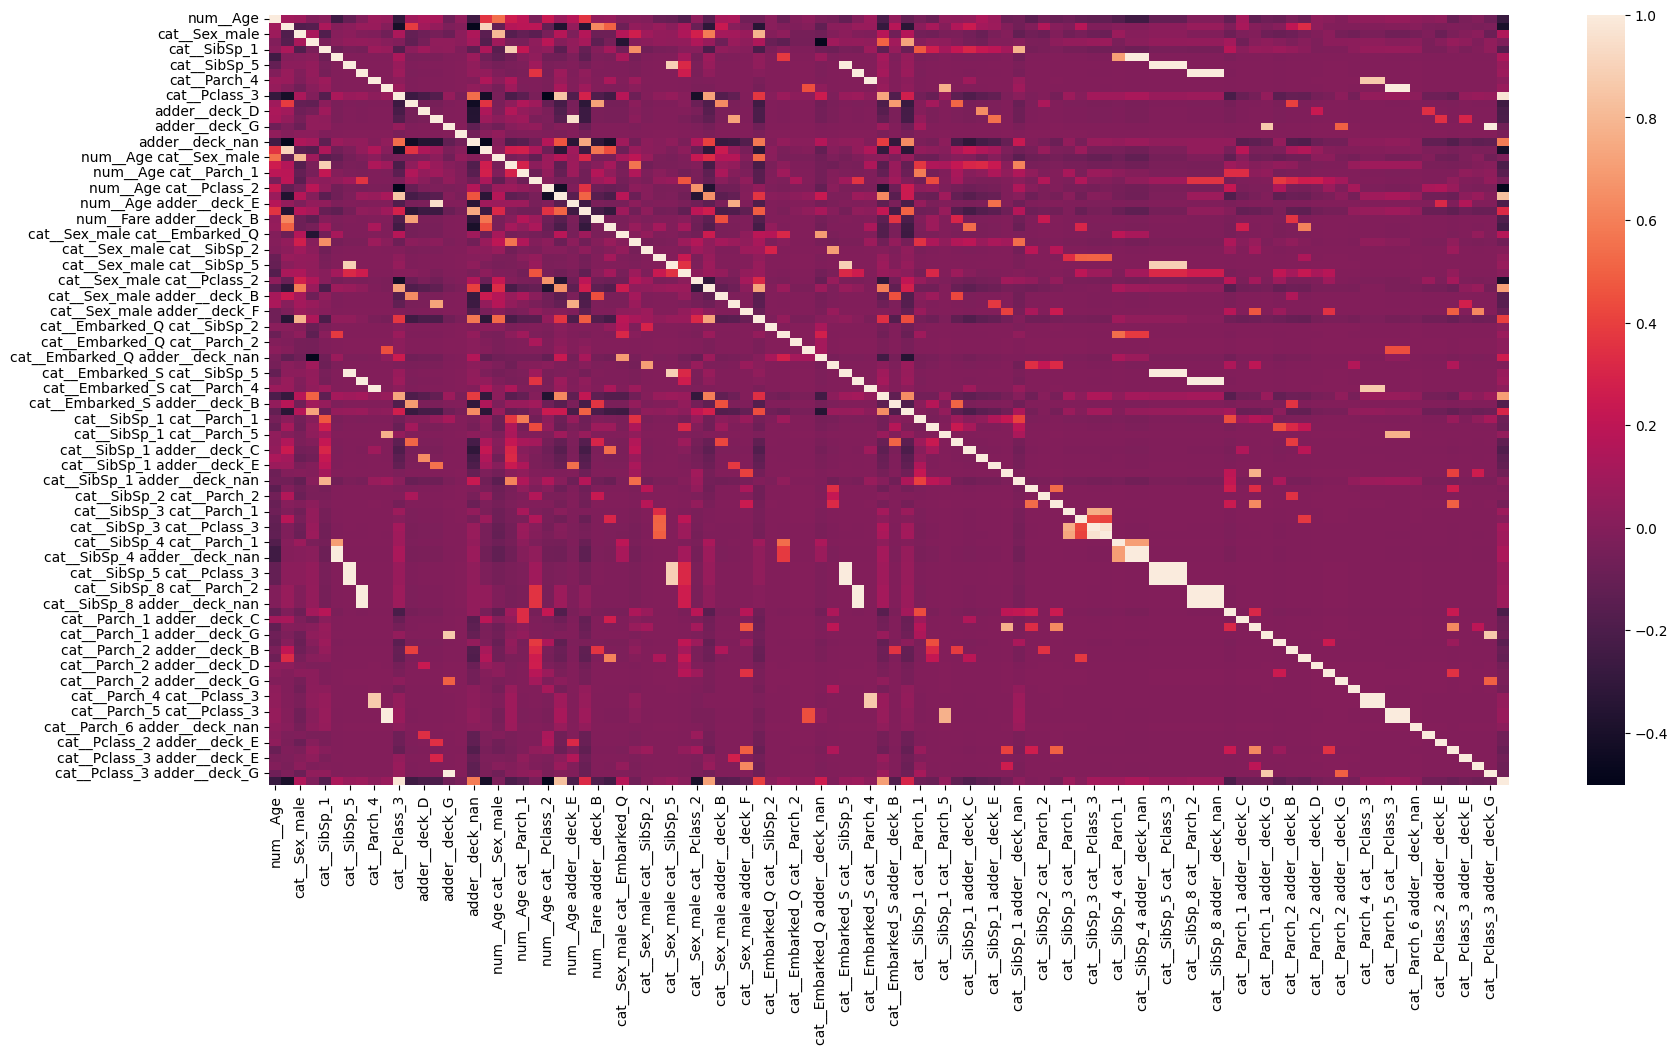

In [57]:
sns.heatmap(X_tr.corr())

### Closer look at classifier

In [58]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

def plot_cm(clf, X, y, title=""):
    f, axs = plt.subplots(1, 3, figsize=(15, 4))

    for ax, normalize in zip(axs, [None, "true", "pred"]):
        ConfusionMatrixDisplay.from_estimator(
            clf, X, y, 
            cmap=plt.cm.Blues, 
            normalize=normalize,
            ax=ax
        )
        ax.set_title("Normalized along: " + str(normalize))
    f.suptitle(title, fontsize=16)

              precision    recall  f1-score   support

           0       0.85      0.93      0.89       549
           1       0.86      0.74      0.80       342

    accuracy                           0.86       891
   macro avg       0.86      0.83      0.84       891
weighted avg       0.86      0.86      0.85       891



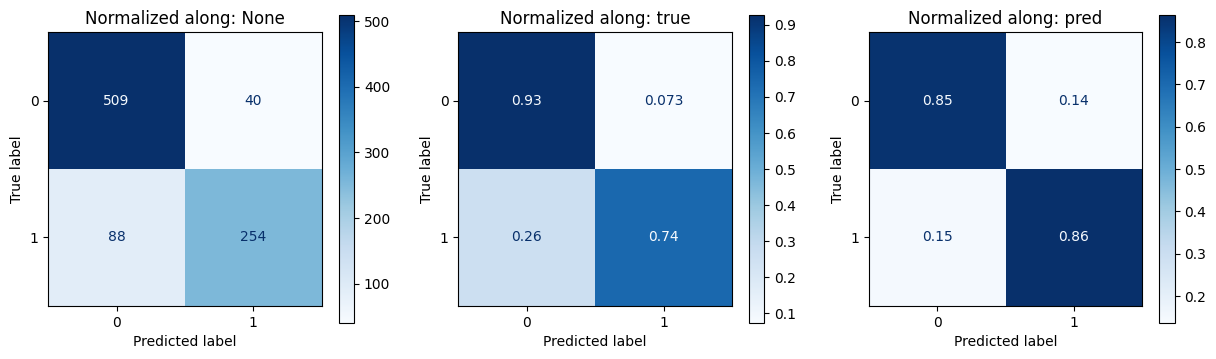

In [59]:
print(classification_report(y, gs.predict(X)))
plot_cm(gs, X, y)

From the right matrix we see that among the predicted outcomes, the results are not that bad: </br>
- High, and most imortantly, comparable 0-1-precision
- Doesn't seem to be a particular preference for either type of error
The left-hand matrix is more problematic:</br>
There seems to be a clear preference for FN error. </br>
It is challenging for our classifier to identify a person, who is likely to survive, that the one, who's not. </br>
This is consistent among the searched estimator: recall-1 is never higher than $75\%$

AUC Score: 0.8349151567443198


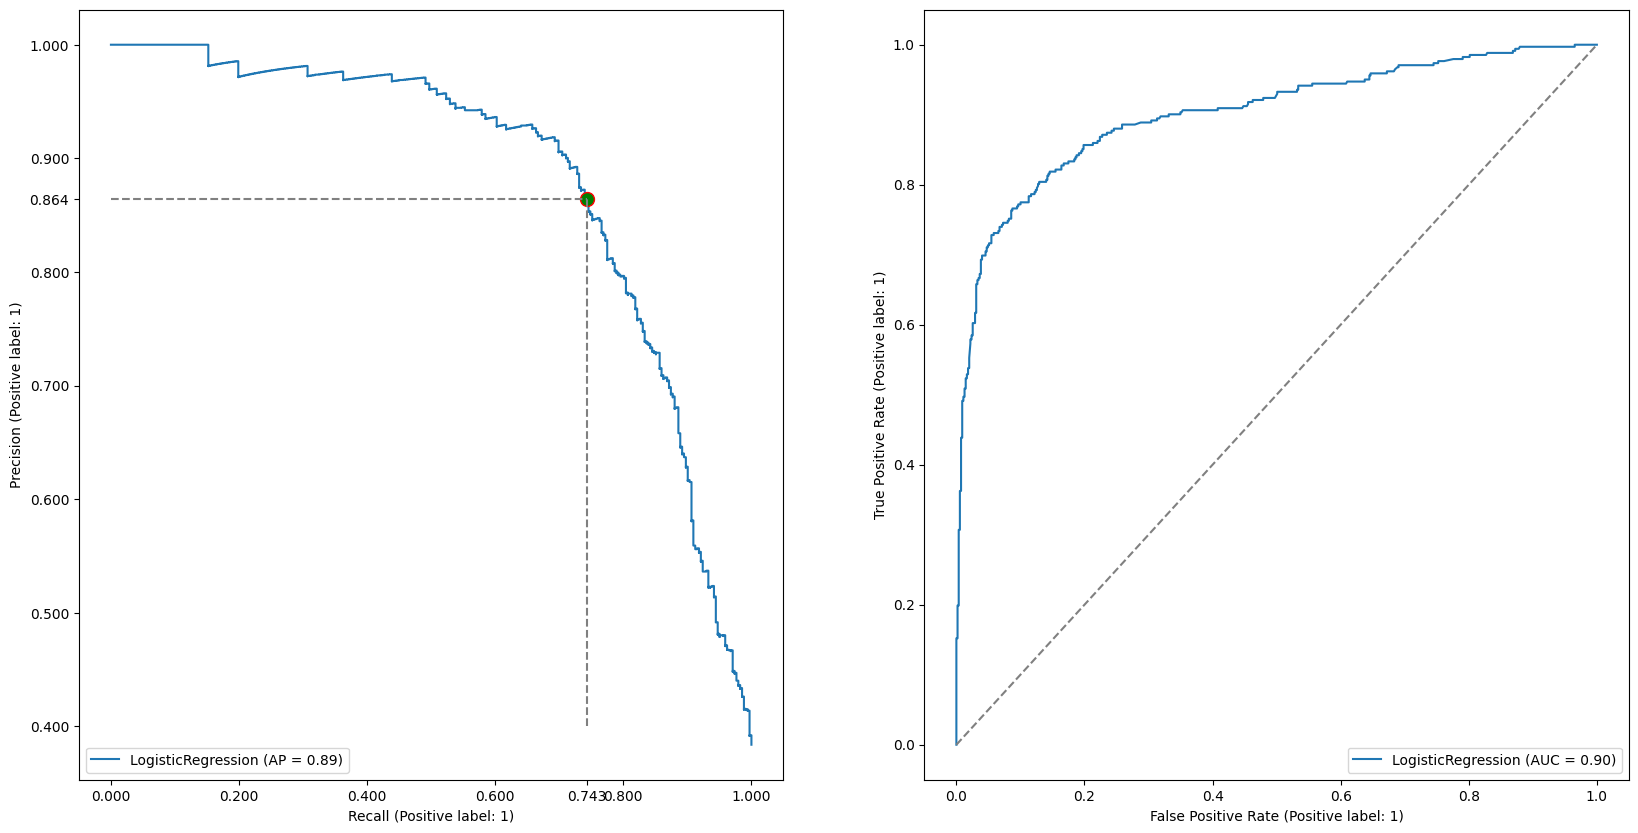

In [60]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import roc_auc_score
f, (ax1, ax2) = plt.subplots(1, 2)

from sklearn.metrics import recall_score, precision_score

rec = recall_score(y, gs.predict(X))
prec = precision_score(y, gs.predict(X))

PrecisionRecallDisplay.from_estimator(
    gs, X, y, name="LogisticRegression", ax=ax1
)
ax1.plot(rec, prec, color="grey",
        marker="o", markersize=10, markeredgecolor="red", markerfacecolor="green")
ax1.plot([rec, rec], [0.4, prec], color="grey", ls='--')
ax1.plot([0, rec], [prec, prec], color="grey", ls='--')
ax1.set_xticks(list(ax1.get_xticks())[1:-1] + [rec])
ax1.set_yticks(list(ax1.get_yticks())[1:-1] + [prec])

RocCurveDisplay.from_estimator(gs, X, y, name="LogisticRegression", ax=ax2)
ax2.plot([0, 1], [0, 1], ls='--', color="grey")
print("AUC Score:", roc_auc_score(y, gs.predict(X)))

### Error analysis

In [61]:
pred = gs.predict(X)
fp_index = y[(y != pred) & (pred == 1)].index
fn_index = y[(y != pred) & (pred == 0)].index
fp_index.shape, fn_index.shape

((40,), (88,))

#### FP -- marked for survival, but did not -- errors
are helpful for us to see which predictors are overrated; which classes are underrepresented

In [62]:
X.iloc[fp_index, :]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
14,3,"Vestrom, Miss. Hulda Amanda Adolfina",female,14.0,0,0,350406,7.8542,NaN,S
41,2,"Turpin, Mrs. William John Robert (Dorothy Ann ...",female,27.0,1,0,11668,21.0000,NaN,S
111,3,"Zabour, Miss. Hileni",female,14.5,1,0,2665,14.4542,NaN,C
114,3,"Attalah, Miss. Malake",female,17.0,0,0,2627,14.4583,NaN,C
118,1,"Baxter, Mr. Quigg Edmond",male,24.0,0,1,PC 17558,247.5208,B58 B60,C
140,3,"Boulos, Mrs. Joseph (Sultana)",female,NaN,0,2,2678,15.2458,NaN,C
177,1,"Isham, Miss. Ann Elizabeth",female,50.0,0,0,PC 17595,28.7125,C49,C
199,2,"Yrois, Miss. Henriette (""Mrs Harbeck"")",female,24.0,0,0,248747,13.0000,NaN,S
240,3,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,NaN,C
246,3,"Lindahl, Miss. Agda Thorilda Viktoria",female,25.0,0,0,347071,7.7750,NaN,S


Observations: mostly females, mostly young people, mostly from the 3 class -- little surprise here. </br>
</br>
Main thing the classifier overlooks, it seems, is that `SibSp__0` and `Parch__0` is actually a very lethal combination; which `Sex`, `Pclass`, or even `Age` do not compensate
</br>
For some reason this combination wasn't chosen by RFE


              precision    recall  f1-score   support

           0       0.86      0.94      0.90       374
           1       0.83      0.65      0.73       163

    accuracy                           0.85       537
   macro avg       0.84      0.80      0.81       537
weighted avg       0.85      0.85      0.85       537



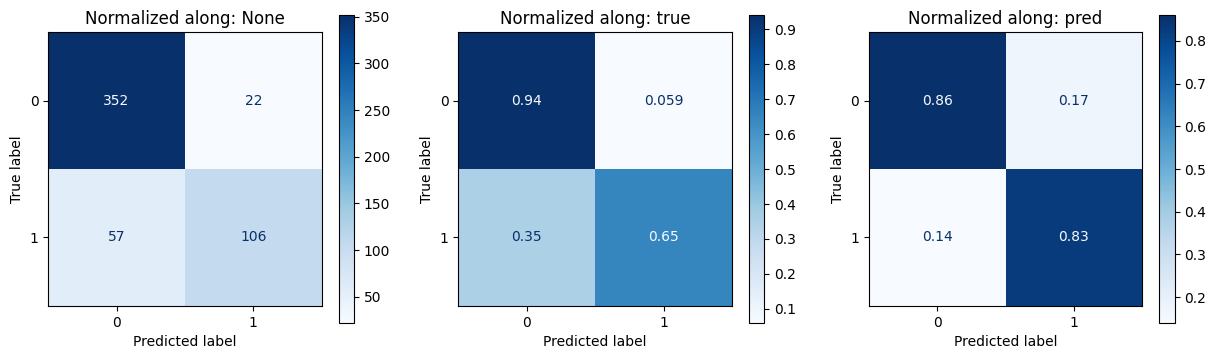

In [63]:
condition = (X["SibSp"] == 0) & (X["Parch"] == 0)
cond_pred = gs.predict(X[condition])
print(classification_report(y[condition], gs.predict(X[condition])))
plot_cm(gs, X[condition], y[condition])

#### FN -- marked for death, but did survive -- errors
are helpful for us to see which important factors (predictors) are not captured, or undermined by the model. </br></br>
The main question for people in this list: what made them survive?

In [64]:
pd.set_option('display.max_rows', None)
X.iloc[fn_index, :]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
8,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.00,0,2,347742,11.1333,NaN,S
17,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
21,2,"Beesley, Mr. Lawrence",male,34.00,0,0,248698,13.0000,D56,S
23,1,"Sloper, Mr. William Thompson",male,28.00,0,0,113788,35.5000,A6,S
25,3,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",female,38.00,1,5,347077,31.3875,NaN,S
36,3,"Mamee, Mr. Hanna",male,NaN,0,0,2677,7.2292,NaN,C
55,1,"Woolner, Mr. Hugh",male,NaN,0,0,19947,35.5000,C52,S
65,3,"Moubarek, Master. Gerios",male,NaN,1,1,2661,15.2458,NaN,C
68,3,"Andersson, Miss. Erna Alexandra",female,17.00,4,2,3101281,7.9250,NaN,S
74,3,"Bing, Mr. Lee",male,32.00,0,0,1601,56.4958,NaN,S


In [65]:
pd.reset_option('display.max_rows', None)

- 233, 261, 305, 489, 788, 803 -- lots of kids were thought to die

Should this result be considered as wrong? After all, the survival rate among kids -- $61\%$ -- is not that high.

- Young 23, 55, 430; and not so young 224, 55, 298, 305, 449, 453, 712

1 class males were marked to death; interestingly, they shared the same `Deck__C`.

In [66]:
survived_summary(["Pclass", "Deck", "SibSp"])

Survived            
                     count sum   ratio
Pclass Deck SibSp                     
1      A    0           13   5   38.5%
            1            2   2  100.0%
       B    0           32  22   68.8%
            1           13  11   84.6%
            2            2   2  100.0%
       C    0           29  17   58.6%
            1           25  15   60.0%
            2            2   1   50.0%
            3            3   2   66.7%
       D    0           15   9   60.0%
            1           14  13   92.9%
       E    0           15  11   73.3%
            1           10   7   70.0%
       T    0            1   0    0.0%
2      D    0            4   3   75.0%
       E    0            4   3   75.0%
       F    0            4   3   75.0%
            1            2   2  100.0%
            2            2   2  100.0%
3      E    0            3   3  100.0%
       F    0            4   0    0.0%
            1            1   1  100.0%
       G    0            2   1   50.0%
            1            2   1   50.0%

### Submission

In [67]:
gs.score(X_train, y_train)

0.8581460674157303

In [68]:
test = pd.read_csv("./test.csv", index_col=0)
print(test.shape)
test.head()

(418, 10)


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [69]:
fin_pred = gs.predict(test)
fin_pred.shape, fin_pred[:5]

C:\Users\леопольд\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


((418,), array([0, 0, 0, 0, 1], dtype=int64))

In [70]:
sub = pd.DataFrame()
sub['PassengerId'] = test.index
sub['Survived'] = fin_pred
sub.to_csv('submission_plain.csv', index=False)